Importación y Carga de Datos

In [74]:
# Importaciones correctas
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = pd.read_csv('telecom_customer_churn.csv')

Preprocesamiento

In [78]:
# 1. Preprocesamiento
# a. Eliminar entradas con el estado "Joined"
df = df[df['Customer Status'] != 'Joined']

# b. Crear la columna 'Churn' y asignar 1 si 'Customer Status' es 'Churned', de lo contrario 0
df['Churn'] = df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)

# c. Eliminar columnas con más del 50% de datos faltantes
threshold = int(0.5 * len(df))
df = df.dropna(thresh=threshold, axis=1)

# d. Imputar valores atípicos usando la mediana (en lugar de la media)
for col in df.select_dtypes(include=['float64', 'int64']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].apply(lambda x: df[col].median() if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)

# e. Convertir variables categóricas a numéricas y llenar valores faltantes

# Separar variables categóricas y numéricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remover 'Customer Status' y 'Churn' de las listas
cat_cols.remove('Customer Status')
num_cols.remove('Churn')

# Crear un transformador de columnas con OneHotEncoder para categóricas y SimpleImputer para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Aplicar el preprocesamiento y obtener las columnas generadas por OneHotEncoder
df_transformed = preprocessor.fit_transform(df)
new_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=cat_cols)
new_cols = num_cols + new_cat_cols.tolist()

# Crear DataFrame preprocesado
df_preprocessed = pd.DataFrame(df_transformed.toarray(), columns=new_cols)
df_preprocessed['Churn'] = df['Churn'].values

# f. Normalización
# Seleccionar solo las columnas que no son 'Churn' para la normalización
cols_to_scale = df_preprocessed.columns.difference(['Churn'])
scaler = StandardScaler()
df_preprocessed[cols_to_scale] = scaler.fit_transform(df_preprocessed[cols_to_scale])

Selección de características

In [79]:
# 2. Selección de características
xgb_for_feature_selection = XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_for_feature_selection.fit(df_preprocessed.drop('Churn', axis=1), df_preprocessed['Churn'])
threshold = 0.01  
selected_features = df_preprocessed.drop('Churn', axis=1).columns[(xgb_for_feature_selection.feature_importances_ > threshold)].tolist()
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['Age', 'Tenure in Months', 'Monthly Charge', 'City_San Diego', 'City_San Dimas', 'Offer_Offer B', 'Internet Service_No', 'Internet Type_Cable', 'Online Security_No', 'Premium Tech Support_No', 'Streaming Movies_Yes', 'Streaming Music_Yes', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year', 'Paperless Billing_No', 'Payment Method_Credit Card']


Balanceo con SMOTE

In [81]:
# 3. Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df_preprocessed[selected_features], df['Churn'])


División de Conjunto

In [82]:
# 4. División de Conjunto
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Definición de la función para crear el modelo ANN

In [83]:
# 5. Definición de la función para crear el modelo ANN
def create_ann_model(learning_rate=0.001):  # Added learning_rate argument with a default value
    ann_model = Sequential()
    ann_model.add(Dense(48, activation='relu', input_dim=len(selected_features)))
    ann_model.add(Dense(1, activation='sigmoid'))  # salida binaria
    ann_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])  # Used learning_rate argument
    return ann_model

ann_model = KerasClassifier(build_fn=create_ann_model, epochs=100, batch_size=32, verbose=0)

Inicializar modelos con los hiperparámetros óptimos encontrados

In [84]:
# 5. Inicializar modelos con los hiperparámetros óptimos encontrados
def objective(trial):
    # Hiperparámetros sugeridos
    xgb_params = {
        'subsample': trial.suggest_float('xgb__subsample', 0.1, 1),
        'scale_pos_weight': trial.suggest_float('xgb__scale_pos_weight', 1, 10),
        'reg_lambda': trial.suggest_float('xgb__reg_lambda', 0.1, 10),
        'n_estimators': trial.suggest_int('xgb__n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb__max_depth', 1, 10),
        'learning_rate': trial.suggest_float('xgb__learning_rate', 0.01, 1, log=True),
        'gamma': trial.suggest_float('xgb__gamma', 0, 1),
        'colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.1, 1),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    rf_params = {
        'n_estimators': trial.suggest_int('rf__n_estimators', 100, 1000),
        'min_samples_split': trial.suggest_int('rf__min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf__min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('rf__max_depth', 1, 10),
        'bootstrap': trial.suggest_categorical('rf__bootstrap', [True, False]),
        'random_state': 42
    }

    ann_params = {
        'epochs': trial.suggest_int('ann__epochs', 10, 200),
        'batch_size': trial.suggest_int('ann__batch_size', 16, 128),
        'learning_rate': trial.suggest_float('ann__learning_rate', 1e-5, 1e-1, log=True)
    }
    xgb_model = XGBClassifier(**xgb_params)
    rf_model = RandomForestClassifier(**rf_params)
    ann_model = KerasClassifier(build_fn=lambda learning_rate=ann_params['learning_rate']: create_ann_model(learning_rate), **ann_params)

    voting_clf = VotingClassifier(
        estimators=[('xgb', xgb_model), ('ann', ann_model), ('rf', rf_model)],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)
    y_pred = voting_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

Crear un Voting Classifier con soft voting

In [85]:
# 7. Creación del estudio Optuna
initial_params = {
    'xgb__subsample': 1.0,
    'xgb__scale_pos_weight': 1,
    'xgb__reg_lambda': 1.0,
    'xgb__n_estimators': 1000,
    'xgb__max_depth': 6,
    'xgb__learning_rate': 0.1,
    'xgb__gamma': 0,
    'xgb__colsample_bytree': 0.9,
    'rf__n_estimators': 300,
    'rf__min_samples_split': 2,
    'rf__min_samples_leaf': 1,
    'rf__max_depth': 8,
    'rf__bootstrap': False,
    'ann__epochs': 100,
    'ann__batch_size': 32,
    'ann__learning_rate': 0.001
}
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.enqueue_trial(initial_params)
study.optimize(objective, n_trials=50, timeout=None)  # Puede ajustar n_trials y timeout según sus necesidades

[I 2023-11-05 16:20:49,752] A new study created in memory with name: no-name-ad0ec194-c5b5-403b-b5d5-f767b97d828f
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
236/236 [==============================] - 4s 6ms/step - loss: 0.4439 - accuracy: 0.7983
Epoch 2/100
236/236 [==============================] - 1s 6ms/step - loss: 0.4213 - accuracy: 0.8071
Epoch 3/100
236/236 [==============================] - 1s 6ms/step - loss: 0.4203 - accuracy: 0.8104
Epoch 4/100
236/236 [==============================] - 1s 5ms/step - loss: 0.4206 - accuracy: 0.8106
Epoch 5/100
236/236 [==============================] - 1s 6ms/step - loss: 0.4205 - accuracy: 0.8130
Epoch 6/100
236/236 [==============================] - 1s 6ms/step - loss: 0.4218 - accuracy: 0.8096
Epoch 7/100
236/236 [==============================] - 1s 5ms/step - loss: 0.4215 - accuracy: 0.8101
Epoch 8/100
236/236 [==============================] - 1s 6ms/step - loss: 0.4208 - accuracy: 0.8102
Epoch 9/100
236/236 [==============================] - 1s 5ms/step - loss: 0.4205 - accuracy: 0.8109
Epoch 10/100
236/236 [==============================] - 1s 5ms/step - loss: 0.4214 - accura

[I 2023-11-05 16:23:11,467] Trial 0 finished with value: 0.8659957627118644 and parameters: {'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 1.0, 'xgb__reg_lambda': 1.0, 'xgb__n_estimators': 1000, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.0, 'xgb__colsample_bytree': 0.9, 'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 8, 'rf__bootstrap': False, 'ann__epochs': 100, 'ann__batch_size': 32, 'ann__learning_rate': 0.001}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/44


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


210/210 [==============================] - 6s 15ms/step - loss: 0.5942 - accuracy: 0.6800
Epoch 2/44
210/210 [==============================] - 2s 8ms/step - loss: 0.4727 - accuracy: 0.7734
Epoch 3/44
210/210 [==============================] - 2s 8ms/step - loss: 0.4464 - accuracy: 0.7893
Epoch 4/44
210/210 [==============================] - 2s 7ms/step - loss: 0.4357 - accuracy: 0.7954
Epoch 5/44
210/210 [==============================] - 2s 7ms/step - loss: 0.4297 - accuracy: 0.8006
Epoch 6/44
210/210 [==============================] - 1s 7ms/step - loss: 0.4261 - accuracy: 0.8039
Epoch 7/44
210/210 [==============================] - 2s 7ms/step - loss: 0.4237 - accuracy: 0.8063
Epoch 8/44
210/210 [==============================] - 2s 7ms/step - loss: 0.4221 - accuracy: 0.8068
Epoch 9/44
210/210 [==============================] - 1s 7ms/step - loss: 0.4209 - accuracy: 0.8071
Epoch 10/44
210/210 [==============================] - 2s 7ms/step - loss: 0.4202 - accuracy: 0.8109
Epoch 11/

[I 2023-11-05 16:24:24,688] Trial 1 finished with value: 0.8199152542372882 and parameters: {'xgb__subsample': 0.4370861069626263, 'xgb__scale_pos_weight': 9.556428757689245, 'xgb__reg_lambda': 7.34674002393291, 'xgb__n_estimators': 639, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.020511104188433976, 'xgb__gamma': 0.05808361216819946, 'xgb__colsample_bytree': 0.8795585311974417, 'rf__n_estimators': 641, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 1, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 44, 'ann__batch_size': 36, 'ann__learning_rate': 0.00016480446427978953}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/42


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


329/329 [==============================] - 7s 12ms/step - loss: 0.6122 - accuracy: 0.7575
Epoch 2/42
329/329 [==============================] - 2s 7ms/step - loss: 0.7339 - accuracy: 0.7479
Epoch 3/42
329/329 [==============================] - 2s 7ms/step - loss: 0.7064 - accuracy: 0.7499
Epoch 4/42
329/329 [==============================] - 2s 7ms/step - loss: 0.9610 - accuracy: 0.7368
Epoch 5/42
329/329 [==============================] - 2s 7ms/step - loss: 0.9456 - accuracy: 0.7446
Epoch 6/42
329/329 [==============================] - 2s 7ms/step - loss: 1.0291 - accuracy: 0.7451
Epoch 7/42
329/329 [==============================] - 2s 7ms/step - loss: 1.4360 - accuracy: 0.7331
Epoch 8/42
329/329 [==============================] - 2s 7ms/step - loss: 1.1223 - accuracy: 0.7352
Epoch 9/42
329/329 [==============================] - 2s 7ms/step - loss: 1.1892 - accuracy: 0.7398
Epoch 10/42
329/329 [==============================] - 2s 7ms/step - loss: 1.5461 - accuracy: 0.7324
Epoch 11/

[I 2023-11-05 16:26:09,955] Trial 2 finished with value: 0.7913135593220338 and parameters: {'xgb__subsample': 0.5722807884690141, 'xgb__scale_pos_weight': 4.887505167779041, 'xgb__reg_lambda': 2.983168487960615, 'xgb__n_estimators': 651, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.03839629299804171, 'xgb__gamma': 0.3663618432936917, 'xgb__colsample_bytree': 0.5104629857953323, 'rf__n_estimators': 807, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 11, 'rf__max_depth': 6, 'rf__bootstrap': False, 'ann__epochs': 42, 'ann__batch_size': 23, 'ann__learning_rate': 0.06245139574743072}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/114


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


210/210 [==============================] - 5s 15ms/step - loss: 0.5891 - accuracy: 0.7648
Epoch 2/114
210/210 [==============================] - 1s 7ms/step - loss: 0.6596 - accuracy: 0.7597
Epoch 3/114
210/210 [==============================] - 1s 7ms/step - loss: 0.7365 - accuracy: 0.7450
Epoch 4/114
210/210 [==============================] - 1s 7ms/step - loss: 0.9054 - accuracy: 0.7440
Epoch 5/114
210/210 [==============================] - 1s 7ms/step - loss: 0.9031 - accuracy: 0.7431
Epoch 6/114
210/210 [==============================] - 1s 7ms/step - loss: 0.9237 - accuracy: 0.7431
Epoch 7/114
210/210 [==============================] - 1s 7ms/step - loss: 0.9352 - accuracy: 0.7468
Epoch 8/114
210/210 [==============================] - 2s 7ms/step - loss: 1.0021 - accuracy: 0.7413
Epoch 9/114
210/210 [==============================] - 1s 7ms/step - loss: 1.0072 - accuracy: 0.7458
Epoch 10/114
210/210 [==============================] - 1s 7ms/step - loss: 1.2744 - accuracy: 0.7311


[I 2023-11-05 16:29:02,929] Trial 3 finished with value: 0.8532838983050848 and parameters: {'xgb__subsample': 0.9690688297671034, 'xgb__scale_pos_weight': 8.275576133048151, 'xgb__reg_lambda': 3.11567631481637, 'xgb__n_estimators': 188, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.07591104805282695, 'xgb__gamma': 0.12203823484477883, 'xgb__colsample_bytree': 0.5456592191001431, 'rf__n_estimators': 130, 'rf__min_samples_split': 19, 'rf__min_samples_leaf': 6, 'rf__max_depth': 7, 'rf__bootstrap': False, 'ann__epochs': 114, 'ann__batch_size': 36, 'ann__learning_rate': 0.07556810141274425}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/113


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


244/244 [==============================] - 6s 14ms/step - loss: 0.4461 - accuracy: 0.8012
Epoch 2/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4574 - accuracy: 0.7920
Epoch 3/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4599 - accuracy: 0.7920
Epoch 4/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4625 - accuracy: 0.7912
Epoch 5/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4893 - accuracy: 0.7875
Epoch 6/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4821 - accuracy: 0.7840
Epoch 7/113
244/244 [==============================] - 2s 7ms/step - loss: 0.5014 - accuracy: 0.7858
Epoch 8/113
244/244 [==============================] - 2s 8ms/step - loss: 0.4765 - accuracy: 0.7852
Epoch 9/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4904 - accuracy: 0.7854
Epoch 10/113
244/244 [==============================] - 2s 7ms/step - loss: 0.4949 - accuracy: 0.7888


[I 2023-11-05 16:32:20,993] Trial 4 finished with value: 0.7902542372881356 and parameters: {'xgb__subsample': 0.7976195410250031, 'xgb__scale_pos_weight': 9.455490474077703, 'xgb__reg_lambda': 8.958790769233723, 'xgb__n_estimators': 638, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.015030900645056829, 'xgb__gamma': 0.1959828624191452, 'xgb__colsample_bytree': 0.14070456001948428, 'rf__n_estimators': 393, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 6, 'rf__max_depth': 9, 'rf__bootstrap': True, 'ann__epochs': 113, 'ann__batch_size': 31, 'ann__learning_rate': 0.016172900811143146}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/73


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


329/329 [==============================] - 6s 11ms/step - loss: 0.5155 - accuracy: 0.7591
Epoch 2/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4504 - accuracy: 0.7949
Epoch 3/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4321 - accuracy: 0.8030
Epoch 4/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4247 - accuracy: 0.8061
Epoch 5/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4216 - accuracy: 0.8087
Epoch 6/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4200 - accuracy: 0.8100
Epoch 7/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4193 - accuracy: 0.8100
Epoch 8/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4187 - accuracy: 0.8133
Epoch 9/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4186 - accuracy: 0.8114
Epoch 10/73
329/329 [==============================] - 2s 7ms/step - loss: 0.4184 - accuracy: 0.8114
Epoch 11/

[I 2023-11-05 16:35:13,108] Trial 5 finished with value: 0.7960805084745762 and parameters: {'xgb__subsample': 0.16709557931179375, 'xgb__scale_pos_weight': 9.881982429404655, 'xgb__reg_lambda': 7.7452232160369086, 'xgb__n_estimators': 279, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.4274869455295215, 'xgb__gamma': 0.7068573438476171, 'xgb__colsample_bytree': 0.7561064512368886, 'rf__n_estimators': 794, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 8, 'rf__max_depth': 2, 'rf__bootstrap': True, 'ann__epochs': 73, 'ann__batch_size': 23, 'ann__learning_rate': 0.00017535949529764417}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


398/398 [==============================] - 7s 11ms/step - loss: 0.4342 - accuracy: 0.8052
Epoch 2/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4273 - accuracy: 0.8065
Epoch 3/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4320 - accuracy: 0.8055
Epoch 4/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4326 - accuracy: 0.8024
Epoch 5/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4329 - accuracy: 0.8008
Epoch 6/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4368 - accuracy: 0.8019
Epoch 7/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4353 - accuracy: 0.8042
Epoch 8/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4397 - accuracy: 0.7999
Epoch 9/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4413 - accuracy: 0.7959
Epoch 10/30
398/398 [==============================] - 3s 7ms/step - loss: 0.4422 - accuracy: 0.8006
Epoch 11/

[I 2023-11-05 16:36:41,688] Trial 6 finished with value: 0.8199152542372882 and parameters: {'xgb__subsample': 0.3926649898240724, 'xgb__scale_pos_weight': 7.566455605042576, 'xgb__reg_lambda': 6.41181896641661, 'xgb__n_estimators': 899, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.017345566642360945, 'xgb__gamma': 0.713244787222995, 'xgb__colsample_bytree': 0.7847065437552077, 'rf__n_estimators': 605, 'rf__min_samples_split': 16, 'rf__min_samples_leaf': 10, 'rf__max_depth': 6, 'rf__bootstrap': True, 'ann__epochs': 30, 'ann__batch_size': 19, 'ann__learning_rate': 0.003512704726270845}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/163


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


205/205 [==============================] - 6s 15ms/step - loss: 0.4726 - accuracy: 0.7860
Epoch 2/163
205/205 [==============================] - 2s 7ms/step - loss: 0.5129 - accuracy: 0.7775
Epoch 3/163
205/205 [==============================] - 1s 7ms/step - loss: 0.5412 - accuracy: 0.7778
Epoch 4/163
205/205 [==============================] - 1s 7ms/step - loss: 0.5696 - accuracy: 0.7711
Epoch 5/163
205/205 [==============================] - 1s 7ms/step - loss: 0.5292 - accuracy: 0.7724
Epoch 6/163
205/205 [==============================] - 1s 7ms/step - loss: 0.6796 - accuracy: 0.7626
Epoch 7/163
205/205 [==============================] - 1s 7ms/step - loss: 0.6149 - accuracy: 0.7662
Epoch 8/163
205/205 [==============================] - 1s 7ms/step - loss: 0.6209 - accuracy: 0.7666
Epoch 9/163
205/205 [==============================] - 1s 7ms/step - loss: 0.6656 - accuracy: 0.7556
Epoch 10/163
205/205 [==============================] - 1s 7ms/step - loss: 0.6365 - accuracy: 0.7577


[I 2023-11-05 16:40:36,246] Trial 7 finished with value: 0.8183262711864406 and parameters: {'xgb__subsample': 0.382920382968694, 'xgb__scale_pos_weight': 5.577136220482325, 'xgb__reg_lambda': 9.084908091868321, 'xgb__n_estimators': 324, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.3244160088734159, 'xgb__gamma': 0.22879816549162246, 'xgb__colsample_bytree': 0.1692819188459137, 'rf__n_estimators': 361, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 19, 'rf__max_depth': 9, 'rf__bootstrap': False, 'ann__epochs': 163, 'ann__batch_size': 37, 'ann__learning_rate': 0.03717371747825049}. Best is trial 0 with value: 0.8659957627118644.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/74
62/62 [==============================] - 5s 35ms/step - loss: 0.7843 - accuracy: 0.4766
Epoch 2/74
62/62 [==============================] - 0s 7ms/step - loss: 0.6095 - accuracy: 0.6776
Epoch 3/74
62/62 [==============================] - 0s 7ms/step - loss: 0.5301 - accuracy: 0.7451
Epoch 4/74
62/62 [==============================] - 0s 8ms/step - loss: 0.4910 - accuracy: 0.7732
Epoch 5/74
62/62 [==============================] - 0s 7ms/step - loss: 0.4687 - accuracy: 0.7852
Epoch 6/74
62/62 [==============================] - 0s 7ms/step - loss: 0.4545 - accuracy: 0.7910
Epoch 7/74
62/62 [==============================] - 0s 7ms/step - loss: 0.4450 - accuracy: 0.7949
Epoch 8/74
62/62 [==============================] - 0s 7ms/step - loss: 0.4382 - accuracy: 0.7970
Epoch 9/74
62/62 [==============================] - 0s 7ms/step - loss: 0.4333 - accuracy: 0.7989
Epoch 10/74
62/62 [==============================] - 0s 7ms/step - loss: 0.4299 - accuracy: 0.7995
Epoch 11/74
62/62 

[I 2023-11-05 16:41:14,339] Trial 8 finished with value: 0.8082627118644068 and parameters: {'xgb__subsample': 0.5854080177240857, 'xgb__scale_pos_weight': 8.266961396476564, 'xgb__reg_lambda': 8.971303869242583, 'xgb__n_estimators': 386, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.02856737429847189, 'xgb__gamma': 0.4271077886262563, 'xgb__colsample_bytree': 0.8362132893302437, 'rf__n_estimators': 875, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 11, 'rf__max_depth': 5, 'rf__bootstrap': True, 'ann__epochs': 74, 'ann__batch_size': 122, 'ann__learning_rate': 0.00019625093208439862}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/183


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


176/176 [==============================] - 5s 16ms/step - loss: 0.6261 - accuracy: 0.6675
Epoch 2/183
176/176 [==============================] - 1s 7ms/step - loss: 0.5679 - accuracy: 0.7153
Epoch 3/183
176/176 [==============================] - 1s 7ms/step - loss: 0.5314 - accuracy: 0.7337
Epoch 4/183
176/176 [==============================] - 1s 7ms/step - loss: 0.5068 - accuracy: 0.7432
Epoch 5/183
176/176 [==============================] - 1s 7ms/step - loss: 0.4896 - accuracy: 0.7540
Epoch 6/183
176/176 [==============================] - 1s 7ms/step - loss: 0.4770 - accuracy: 0.7624
Epoch 7/183
176/176 [==============================] - 1s 7ms/step - loss: 0.4673 - accuracy: 0.7685
Epoch 8/183
176/176 [==============================] - 1s 7ms/step - loss: 0.4598 - accuracy: 0.7757
Epoch 9/183
176/176 [==============================] - 1s 7ms/step - loss: 0.4538 - accuracy: 0.7794
Epoch 10/183
176/176 [==============================] - 1s 7ms/step - loss: 0.4488 - accuracy: 0.7840


[I 2023-11-05 16:45:01,708] Trial 9 finished with value: 0.8501059322033898 and parameters: {'xgb__subsample': 0.5669115595690295, 'xgb__scale_pos_weight': 7.3271706300566, 'xgb__reg_lambda': 3.6999330635550107, 'xgb__n_estimators': 975, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.031883397351001874, 'xgb__gamma': 0.49724850589238545, 'xgb__colsample_bytree': 0.37079047883509275, 'rf__n_estimators': 356, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 13, 'rf__max_depth': 6, 'rf__bootstrap': False, 'ann__epochs': 183, 'ann__batch_size': 43, 'ann__learning_rate': 3.798214508453257e-05}. Best is trial 0 with value: 0.8659957627118644.


Epoch 1/138


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


108/108 [==============================] - 5s 23ms/step - loss: 0.4477 - accuracy: 0.7930
Epoch 2/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4217 - accuracy: 0.8085
Epoch 3/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4202 - accuracy: 0.8092
Epoch 4/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4206 - accuracy: 0.8129
Epoch 5/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4212 - accuracy: 0.8110
Epoch 6/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4210 - accuracy: 0.8113
Epoch 7/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4205 - accuracy: 0.8109
Epoch 8/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4208 - accuracy: 0.8112
Epoch 9/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4199 - accuracy: 0.8110
Epoch 10/138
108/108 [==============================] - 1s 7ms/step - loss: 0.4202 - accuracy: 0.8117


[I 2023-11-05 16:46:52,393] Trial 10 finished with value: 0.868114406779661 and parameters: {'xgb__subsample': 0.9814934905125248, 'xgb__scale_pos_weight': 1.053974646602354, 'xgb__reg_lambda': 0.17471846123130153, 'xgb__n_estimators': 829, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.16638185017877255, 'xgb__gamma': 0.015165720318569761, 'xgb__colsample_bytree': 0.978843961022449, 'rf__n_estimators': 138, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 1, 'rf__max_depth': 2, 'rf__bootstrap': False, 'ann__epochs': 138, 'ann__batch_size': 70, 'ann__learning_rate': 0.0015964544596507545}. Best is trial 10 with value: 0.868114406779661.


Epoch 1/148


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


104/104 [==============================] - 5s 24ms/step - loss: 0.4857 - accuracy: 0.7566
Epoch 2/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4241 - accuracy: 0.8079
Epoch 3/148
104/104 [==============================] - 1s 8ms/step - loss: 0.4211 - accuracy: 0.8104
Epoch 4/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4202 - accuracy: 0.8080
Epoch 5/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4207 - accuracy: 0.8100
Epoch 6/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4206 - accuracy: 0.8130
Epoch 7/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4218 - accuracy: 0.8106
Epoch 8/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4211 - accuracy: 0.8077
Epoch 9/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4215 - accuracy: 0.8110
Epoch 10/148
104/104 [==============================] - 1s 7ms/step - loss: 0.4204 - accuracy: 0.8110


[I 2023-11-05 16:48:48,942] Trial 11 finished with value: 0.871822033898305 and parameters: {'xgb__subsample': 0.9918536708481084, 'xgb__scale_pos_weight': 1.0704484490101513, 'xgb__reg_lambda': 0.1776051958904159, 'xgb__n_estimators': 820, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.14221808656348645, 'xgb__gamma': 0.03454861691481451, 'xgb__colsample_bytree': 0.9597235316392483, 'rf__n_estimators': 114, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 1, 'rf__bootstrap': False, 'ann__epochs': 148, 'ann__batch_size': 73, 'ann__learning_rate': 0.001855241654243998}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/154


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


99/99 [==============================] - 5s 25ms/step - loss: 0.4395 - accuracy: 0.8003
Epoch 2/154
99/99 [==============================] - 1s 8ms/step - loss: 0.4234 - accuracy: 0.8091
Epoch 3/154
99/99 [==============================] - 1s 7ms/step - loss: 0.4212 - accuracy: 0.8144
Epoch 4/154
99/99 [==============================] - 1s 8ms/step - loss: 0.4231 - accuracy: 0.8072
Epoch 5/154
99/99 [==============================] - 1s 7ms/step - loss: 0.4224 - accuracy: 0.8080
Epoch 6/154
99/99 [==============================] - 1s 8ms/step - loss: 0.4218 - accuracy: 0.8076
Epoch 7/154
99/99 [==============================] - 1s 8ms/step - loss: 0.4264 - accuracy: 0.8053
Epoch 8/154
99/99 [==============================] - 1s 8ms/step - loss: 0.4269 - accuracy: 0.8065
Epoch 9/154
99/99 [==============================] - 1s 7ms/step - loss: 0.4265 - accuracy: 0.8069
Epoch 10/154
99/99 [==============================] - 1s 7ms/step - loss: 0.4287 - accuracy: 0.8022
Epoch 11/154
99/99 [

[I 2023-11-05 16:50:43,647] Trial 12 finished with value: 0.8532838983050848 and parameters: {'xgb__subsample': 0.833305347104408, 'xgb__scale_pos_weight': 1.1728932911205312, 'xgb__reg_lambda': 0.3572115386561307, 'xgb__n_estimators': 807, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.21062720567129056, 'xgb__gamma': 0.2811625791970913, 'xgb__colsample_bytree': 0.9964152904250919, 'rf__n_estimators': 126, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 1, 'rf__bootstrap': False, 'ann__epochs': 154, 'ann__batch_size': 77, 'ann__learning_rate': 0.003130345981160326}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/145


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


103/103 [==============================] - 6s 23ms/step - loss: 0.4595 - accuracy: 0.7871
Epoch 2/145
103/103 [==============================] - 1s 7ms/step - loss: 0.4213 - accuracy: 0.8105
Epoch 3/145
103/103 [==============================] - 1s 7ms/step - loss: 0.4207 - accuracy: 0.8108
Epoch 4/145
103/103 [==============================] - 1s 7ms/step - loss: 0.4203 - accuracy: 0.8101
Epoch 5/145
103/103 [==============================] - 1s 7ms/step - loss: 0.4202 - accuracy: 0.8114
Epoch 6/145
103/103 [==============================] - 1s 8ms/step - loss: 0.4197 - accuracy: 0.8114
Epoch 7/145
103/103 [==============================] - 1s 8ms/step - loss: 0.4207 - accuracy: 0.8097
Epoch 8/145
103/103 [==============================] - 1s 8ms/step - loss: 0.4210 - accuracy: 0.8077
Epoch 9/145
103/103 [==============================] - 1s 8ms/step - loss: 0.4204 - accuracy: 0.8091
Epoch 10/145
103/103 [==============================] - 1s 8ms/step - loss: 0.4211 - accuracy: 0.8138


[I 2023-11-05 16:52:36,200] Trial 13 finished with value: 0.8649364406779662 and parameters: {'xgb__subsample': 0.8290957749718659, 'xgb__scale_pos_weight': 2.349305431298755, 'xgb__reg_lambda': 1.3835670516098517, 'xgb__n_estimators': 781, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.9006020499939716, 'xgb__gamma': 0.004740119653089181, 'xgb__colsample_bytree': 0.9666877688539538, 'rf__n_estimators': 222, 'rf__min_samples_split': 13, 'rf__min_samples_leaf': 3, 'rf__max_depth': 3, 'rf__bootstrap': False, 'ann__epochs': 145, 'ann__batch_size': 74, 'ann__learning_rate': 0.0015504255306959505}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/193


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


80/80 [==============================] - 5s 28ms/step - loss: 0.4450 - accuracy: 0.7969
Epoch 2/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4287 - accuracy: 0.8071
Epoch 3/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4302 - accuracy: 0.8077
Epoch 4/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4290 - accuracy: 0.8050
Epoch 5/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4281 - accuracy: 0.8056
Epoch 6/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4363 - accuracy: 0.8028
Epoch 7/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4373 - accuracy: 0.8030
Epoch 8/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4356 - accuracy: 0.8030
Epoch 9/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4357 - accuracy: 0.8044
Epoch 10/193
80/80 [==============================] - 1s 7ms/step - loss: 0.4361 - accuracy: 0.8002
Epoch 11/193
80/80 [

[I 2023-11-05 16:54:29,080] Trial 14 finished with value: 0.8389830508474576 and parameters: {'xgb__subsample': 0.9876451834239529, 'xgb__scale_pos_weight': 2.65227116375866, 'xgb__reg_lambda': 0.42624425439599856, 'xgb__n_estimators': 489, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.17982068728458964, 'xgb__gamma': 0.1981852080586859, 'xgb__colsample_bytree': 0.7041132706154966, 'rf__n_estimators': 484, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 17, 'rf__max_depth': 4, 'rf__bootstrap': False, 'ann__epochs': 193, 'ann__batch_size': 95, 'ann__learning_rate': 0.009392822547774722}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/132


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


138/138 [==============================] - 5s 19ms/step - loss: 0.4658 - accuracy: 0.7770
Epoch 2/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4222 - accuracy: 0.8076
Epoch 3/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4197 - accuracy: 0.8125
Epoch 4/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4196 - accuracy: 0.8125
Epoch 5/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4193 - accuracy: 0.8117
Epoch 6/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4196 - accuracy: 0.8122
Epoch 7/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4194 - accuracy: 0.8104
Epoch 8/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4194 - accuracy: 0.8116
Epoch 9/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4196 - accuracy: 0.8133
Epoch 10/132
138/138 [==============================] - 1s 7ms/step - loss: 0.4191 - accuracy: 0.8118


[I 2023-11-05 16:56:41,624] Trial 15 finished with value: 0.8654661016949152 and parameters: {'xgb__subsample': 0.6950249679974813, 'xgb__scale_pos_weight': 2.7080190363752976, 'xgb__reg_lambda': 1.9992429691787816, 'xgb__n_estimators': 822, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.06613644475520926, 'xgb__gamma': 0.12014161705259714, 'xgb__colsample_bytree': 0.9889032044479069, 'rf__n_estimators': 215, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 4, 'rf__max_depth': 1, 'rf__bootstrap': False, 'ann__epochs': 132, 'ann__batch_size': 55, 'ann__learning_rate': 0.0008234957558924858}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/172


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


126/126 [==============================] - 5s 21ms/step - loss: 0.4354 - accuracy: 0.7993
Epoch 2/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4368 - accuracy: 0.7985
Epoch 3/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4436 - accuracy: 0.7958
Epoch 4/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4378 - accuracy: 0.7989
Epoch 5/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4406 - accuracy: 0.7959
Epoch 6/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4491 - accuracy: 0.7965
Epoch 7/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4655 - accuracy: 0.7887
Epoch 8/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4579 - accuracy: 0.7971
Epoch 9/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4409 - accuracy: 0.7983
Epoch 10/172
126/126 [==============================] - 1s 7ms/step - loss: 0.4564 - accuracy: 0.7941


[I 2023-11-05 16:59:15,953] Trial 16 finished with value: 0.8310381355932204 and parameters: {'xgb__subsample': 0.8984831835758813, 'xgb__scale_pos_weight': 3.7463110546781566, 'xgb__reg_lambda': 4.519347751919695, 'xgb__n_estimators': 731, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.15634692717182067, 'xgb__gamma': 0.9585999907324434, 'xgb__colsample_bytree': 0.6662180113904742, 'rf__n_estimators': 112, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 1, 'rf__max_depth': 3, 'rf__bootstrap': False, 'ann__epochs': 172, 'ann__batch_size': 60, 'ann__learning_rate': 0.011404525346809694}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/133


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


83/83 [==============================] - 5s 27ms/step - loss: 0.5854 - accuracy: 0.7268
Epoch 2/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5773 - accuracy: 0.7293
Epoch 3/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5698 - accuracy: 0.7327
Epoch 4/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5629 - accuracy: 0.7344
Epoch 5/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5566 - accuracy: 0.7369
Epoch 6/133
83/83 [==============================] - 1s 9ms/step - loss: 0.5509 - accuracy: 0.7401
Epoch 7/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5457 - accuracy: 0.7415
Epoch 8/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5407 - accuracy: 0.7451
Epoch 9/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5362 - accuracy: 0.7463
Epoch 10/133
83/83 [==============================] - 1s 7ms/step - loss: 0.5319 - accuracy: 0.7489
Epoch 11/133
83/83 [

[I 2023-11-05 17:00:40,039] Trial 17 finished with value: 0.8379237288135594 and parameters: {'xgb__subsample': 0.7336242598061354, 'xgb__scale_pos_weight': 1.6946669768022522, 'xgb__reg_lambda': 2.08126594611339, 'xgb__n_estimators': 548, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.055076413726981105, 'xgb__gamma': 0.10345668642311799, 'xgb__colsample_bytree': 0.864783427328954, 'rf__n_estimators': 1000, 'rf__min_samples_split': 11, 'rf__min_samples_leaf': 15, 'rf__max_depth': 2, 'rf__bootstrap': False, 'ann__epochs': 133, 'ann__batch_size': 92, 'ann__learning_rate': 1.1969062590495695e-05}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/86


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


81/81 [==============================] - 5s 28ms/step - loss: 0.6856 - accuracy: 0.5934
Epoch 2/86
81/81 [==============================] - 1s 9ms/step - loss: 0.5085 - accuracy: 0.7556
Epoch 3/86
81/81 [==============================] - 1s 7ms/step - loss: 0.4618 - accuracy: 0.7854
Epoch 4/86
81/81 [==============================] - 1s 8ms/step - loss: 0.4430 - accuracy: 0.7933
Epoch 5/86
81/81 [==============================] - 1s 8ms/step - loss: 0.4333 - accuracy: 0.8014
Epoch 6/86
81/81 [==============================] - 1s 8ms/step - loss: 0.4275 - accuracy: 0.8046
Epoch 7/86
81/81 [==============================] - 1s 8ms/step - loss: 0.4240 - accuracy: 0.8069
Epoch 8/86
81/81 [==============================] - 1s 8ms/step - loss: 0.4219 - accuracy: 0.8099
Epoch 9/86
81/81 [==============================] - 1s 7ms/step - loss: 0.4206 - accuracy: 0.8084
Epoch 10/86
81/81 [==============================] - 1s 8ms/step - loss: 0.4198 - accuracy: 0.8110
Epoch 11/86
81/81 [==========

[I 2023-11-05 17:01:38,512] Trial 18 finished with value: 0.864406779661017 and parameters: {'xgb__subsample': 0.8934171115567722, 'xgb__scale_pos_weight': 2.009092160742322, 'xgb__reg_lambda': 1.6341148385721318, 'xgb__n_estimators': 859, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.10999325970626125, 'xgb__gamma': 0.32605929290880387, 'xgb__colsample_bytree': 0.6682331818186819, 'rf__n_estimators': 460, 'rf__min_samples_split': 14, 'rf__min_samples_leaf': 6, 'rf__max_depth': 4, 'rf__bootstrap': False, 'ann__epochs': 86, 'ann__batch_size': 94, 'ann__learning_rate': 0.0003564788674411222}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/133


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


65/65 [==============================] - 5s 35ms/step - loss: 0.4593 - accuracy: 0.7843
Epoch 2/133
65/65 [==============================] - 1s 8ms/step - loss: 0.4234 - accuracy: 0.8076
Epoch 3/133
65/65 [==============================] - 1s 8ms/step - loss: 0.4212 - accuracy: 0.8112
Epoch 4/133
65/65 [==============================] - 1s 8ms/step - loss: 0.4218 - accuracy: 0.8108
Epoch 5/133
65/65 [==============================] - 1s 8ms/step - loss: 0.4242 - accuracy: 0.8089
Epoch 6/133
65/65 [==============================] - 1s 8ms/step - loss: 0.4236 - accuracy: 0.8081
Epoch 7/133
65/65 [==============================] - 0s 8ms/step - loss: 0.4214 - accuracy: 0.8091
Epoch 8/133
65/65 [==============================] - 0s 8ms/step - loss: 0.4234 - accuracy: 0.8068
Epoch 9/133
65/65 [==============================] - 0s 7ms/step - loss: 0.4231 - accuracy: 0.8092
Epoch 10/133
65/65 [==============================] - 1s 8ms/step - loss: 0.4239 - accuracy: 0.8067
Epoch 11/133
65/65 [

[I 2023-11-05 17:02:46,934] Trial 19 finished with value: 0.8591101694915254 and parameters: {'xgb__subsample': 0.9028649723799559, 'xgb__scale_pos_weight': 3.2035942993251103, 'xgb__reg_lambda': 0.3178429359348218, 'xgb__n_estimators': 907, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.12027872127535497, 'xgb__gamma': 0.003062622459196262, 'xgb__colsample_bytree': 0.9149744197310914, 'rf__n_estimators': 232, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 3, 'rf__max_depth': 1, 'rf__bootstrap': False, 'ann__epochs': 133, 'ann__batch_size': 117, 'ann__learning_rate': 0.0037527230694106026}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/175


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


124/124 [==============================] - 5s 21ms/step - loss: 0.5777 - accuracy: 0.6950
Epoch 2/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4459 - accuracy: 0.7903
Epoch 3/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4283 - accuracy: 0.8010
Epoch 4/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4226 - accuracy: 0.8055
Epoch 5/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4206 - accuracy: 0.8096
Epoch 6/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4198 - accuracy: 0.8092
Epoch 7/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4192 - accuracy: 0.8112
Epoch 8/175
124/124 [==============================] - 1s 7ms/step - loss: 0.4187 - accuracy: 0.8118
Epoch 9/175
124/124 [==============================] - 1s 9ms/step - loss: 0.4186 - accuracy: 0.8122
Epoch 10/175
124/124 [==============================] - 1s 9ms/step - loss: 0.4188 - accuracy: 0.8114


[I 2023-11-05 17:05:26,507] Trial 20 finished with value: 0.864406779661017 and parameters: {'xgb__subsample': 0.7394018087175276, 'xgb__scale_pos_weight': 1.5546975471929407, 'xgb__reg_lambda': 2.7190765595914996, 'xgb__n_estimators': 723, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.2919593000885767, 'xgb__gamma': 0.16493840981581026, 'xgb__colsample_bytree': 0.7735585519204902, 'rf__n_estimators': 269, 'rf__min_samples_split': 17, 'rf__min_samples_leaf': 8, 'rf__max_depth': 2, 'rf__bootstrap': False, 'ann__epochs': 175, 'ann__batch_size': 61, 'ann__learning_rate': 0.0005688216921709183}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/96


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


93/93 [==============================] - 5s 25ms/step - loss: 0.4720 - accuracy: 0.7764
Epoch 2/96
93/93 [==============================] - 1s 8ms/step - loss: 0.4221 - accuracy: 0.8068
Epoch 3/96
93/93 [==============================] - 1s 8ms/step - loss: 0.4200 - accuracy: 0.8116
Epoch 4/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4201 - accuracy: 0.8117
Epoch 5/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4199 - accuracy: 0.8141
Epoch 6/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4197 - accuracy: 0.8105
Epoch 7/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4198 - accuracy: 0.8113
Epoch 8/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4197 - accuracy: 0.8104
Epoch 9/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4197 - accuracy: 0.8114
Epoch 10/96
93/93 [==============================] - 1s 7ms/step - loss: 0.4200 - accuracy: 0.8105
Epoch 11/96
93/93 [==========

[I 2023-11-05 17:06:34,247] Trial 21 finished with value: 0.8649364406779662 and parameters: {'xgb__subsample': 0.9901186929167496, 'xgb__scale_pos_weight': 1.0519915193224583, 'xgb__reg_lambda': 1.1266829754359176, 'xgb__n_estimators': 998, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.10814519313221996, 'xgb__gamma': 0.005223177926466182, 'xgb__colsample_bytree': 0.912185596091546, 'rf__n_estimators': 295, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 7, 'rf__bootstrap': False, 'ann__epochs': 96, 'ann__batch_size': 82, 'ann__learning_rate': 0.0013818406565172863}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/115


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


152/152 [==============================] - 6s 21ms/step - loss: 0.4755 - accuracy: 0.7700
Epoch 2/115
152/152 [==============================] - 1s 8ms/step - loss: 0.4230 - accuracy: 0.8077
Epoch 3/115
152/152 [==============================] - 1s 7ms/step - loss: 0.4202 - accuracy: 0.8102
Epoch 4/115
152/152 [==============================] - 1s 7ms/step - loss: 0.4205 - accuracy: 0.8108
Epoch 5/115
152/152 [==============================] - 1s 8ms/step - loss: 0.4203 - accuracy: 0.8125
Epoch 6/115
152/152 [==============================] - 1s 8ms/step - loss: 0.4210 - accuracy: 0.8113
Epoch 7/115
152/152 [==============================] - 1s 7ms/step - loss: 0.4211 - accuracy: 0.8087
Epoch 8/115
152/152 [==============================] - 1s 8ms/step - loss: 0.4206 - accuracy: 0.8106
Epoch 9/115
152/152 [==============================] - 1s 7ms/step - loss: 0.4215 - accuracy: 0.8093
Epoch 10/115
152/152 [==============================] - 1s 8ms/step - loss: 0.4211 - accuracy: 0.8105


[I 2023-11-05 17:08:47,448] Trial 22 finished with value: 0.8649364406779662 and parameters: {'xgb__subsample': 0.9800943552417504, 'xgb__scale_pos_weight': 1.2277936305834807, 'xgb__reg_lambda': 0.9113463377988336, 'xgb__n_estimators': 954, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.08472542983160036, 'xgb__gamma': 0.09058238367592827, 'xgb__colsample_bytree': 0.9245450239079204, 'rf__n_estimators': 178, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 3, 'rf__max_depth': 8, 'rf__bootstrap': False, 'ann__epochs': 115, 'ann__batch_size': 50, 'ann__learning_rate': 0.0014614105526395303}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/150


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


69/69 [==============================] - 5s 35ms/step - loss: 0.4488 - accuracy: 0.7926
Epoch 2/150
69/69 [==============================] - 1s 8ms/step - loss: 0.4207 - accuracy: 0.8085
Epoch 3/150
69/69 [==============================] - 1s 8ms/step - loss: 0.4208 - accuracy: 0.8104
Epoch 4/150
69/69 [==============================] - 1s 8ms/step - loss: 0.4209 - accuracy: 0.8105
Epoch 5/150
69/69 [==============================] - 0s 7ms/step - loss: 0.4218 - accuracy: 0.8113
Epoch 6/150
69/69 [==============================] - 0s 7ms/step - loss: 0.4198 - accuracy: 0.8104
Epoch 7/150
69/69 [==============================] - 0s 7ms/step - loss: 0.4209 - accuracy: 0.8130
Epoch 8/150
69/69 [==============================] - 1s 8ms/step - loss: 0.4205 - accuracy: 0.8116
Epoch 9/150
69/69 [==============================] - 0s 7ms/step - loss: 0.4227 - accuracy: 0.8108
Epoch 10/150
69/69 [==============================] - 0s 7ms/step - loss: 0.4212 - accuracy: 0.8087
Epoch 11/150
69/69 [

[I 2023-11-05 17:10:10,772] Trial 23 finished with value: 0.8564618644067796 and parameters: {'xgb__subsample': 0.9964616040885025, 'xgb__scale_pos_weight': 2.073312127336292, 'xgb__reg_lambda': 0.1525096217381634, 'xgb__n_estimators': 894, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.14754171871364666, 'xgb__gamma': 0.2435145544787718, 'xgb__colsample_bytree': 0.9895130568829145, 'rf__n_estimators': 320, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 1, 'rf__max_depth': 3, 'rf__bootstrap': False, 'ann__epochs': 150, 'ann__batch_size': 110, 'ann__learning_rate': 0.002544235702830974}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/93


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


118/118 [==============================] - 3s 8ms/step - loss: 0.5611 - accuracy: 0.6903
Epoch 2/93
118/118 [==============================] - 1s 6ms/step - loss: 0.4400 - accuracy: 0.7921
Epoch 3/93
118/118 [==============================] - 1s 6ms/step - loss: 0.4272 - accuracy: 0.8024
Epoch 4/93
118/118 [==============================] - 1s 7ms/step - loss: 0.4228 - accuracy: 0.8067
Epoch 5/93
118/118 [==============================] - 1s 6ms/step - loss: 0.4205 - accuracy: 0.8088
Epoch 6/93
118/118 [==============================] - 1s 6ms/step - loss: 0.4198 - accuracy: 0.8132
Epoch 7/93
118/118 [==============================] - 1s 6ms/step - loss: 0.4193 - accuracy: 0.8106
Epoch 8/93
118/118 [==============================] - 1s 7ms/step - loss: 0.4190 - accuracy: 0.8106
Epoch 9/93
118/118 [==============================] - 1s 7ms/step - loss: 0.4190 - accuracy: 0.8118
Epoch 10/93
118/118 [==============================] - 1s 6ms/step - loss: 0.4189 - accuracy: 0.8116
Epoch 11/9

[I 2023-11-05 17:11:41,194] Trial 24 finished with value: 0.8479872881355932 and parameters: {'xgb__subsample': 0.9025214791436944, 'xgb__scale_pos_weight': 1.0578353867912549, 'xgb__reg_lambda': 1.089776833302456, 'xgb__n_estimators': 739, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.010123622038071494, 'xgb__gamma': 0.07712536580552301, 'xgb__colsample_bytree': 0.8387789425643264, 'rf__n_estimators': 167, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 5, 'rf__max_depth': 4, 'rf__bootstrap': False, 'ann__epochs': 93, 'ann__batch_size': 64, 'ann__learning_rate': 0.0005942786246809006}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/122


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 7s 39ms/step - loss: 0.4382 - accuracy: 0.7979
Epoch 2/122
90/90 [==============================] - 1s 12ms/step - loss: 0.4222 - accuracy: 0.8079
Epoch 3/122
90/90 [==============================] - 1s 12ms/step - loss: 0.4280 - accuracy: 0.8069
Epoch 4/122
90/90 [==============================] - 1s 11ms/step - loss: 0.4244 - accuracy: 0.8101
Epoch 5/122
90/90 [==============================] - 1s 11ms/step - loss: 0.4313 - accuracy: 0.8068
Epoch 6/122
90/90 [==============================] - 1s 11ms/step - loss: 0.4339 - accuracy: 0.8003
Epoch 7/122
90/90 [==============================] - 1s 10ms/step - loss: 0.4293 - accuracy: 0.8068
Epoch 8/122
90/90 [==============================] - 1s 10ms/step - loss: 0.4274 - accuracy: 0.8081
Epoch 9/122
90/90 [==============================] - 1s 10ms/step - loss: 0.4478 - accuracy: 0.7958
Epoch 10/122
90/90 [==============================] - 1s 12ms/step - loss: 0.4296 - accuracy: 0.8036
Epoch 11/12

[I 2023-11-05 17:13:22,354] Trial 25 finished with value: 0.8697033898305084 and parameters: {'xgb__subsample': 0.9233806125507804, 'xgb__scale_pos_weight': 3.3209774529885707, 'xgb__reg_lambda': 2.1803700840125364, 'xgb__n_estimators': 999, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05039906127933683, 'xgb__gamma': 0.16431762039834208, 'xgb__colsample_bytree': 0.9145350763900154, 'rf__n_estimators': 453, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 2, 'rf__max_depth': 10, 'rf__bootstrap': False, 'ann__epochs': 122, 'ann__batch_size': 84, 'ann__learning_rate': 0.006318259715531871}. Best is trial 11 with value: 0.871822033898305.


Epoch 1/124


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 5s 30ms/step - loss: 0.4614 - accuracy: 0.7875
Epoch 2/124
90/90 [==============================] - 1s 9ms/step - loss: 0.4235 - accuracy: 0.8100
Epoch 3/124
90/90 [==============================] - 1s 9ms/step - loss: 0.4268 - accuracy: 0.8068
Epoch 4/124
90/90 [==============================] - 1s 7ms/step - loss: 0.4294 - accuracy: 0.8065
Epoch 5/124
90/90 [==============================] - 1s 7ms/step - loss: 0.4283 - accuracy: 0.8050
Epoch 6/124
90/90 [==============================] - 1s 7ms/step - loss: 0.4299 - accuracy: 0.8067
Epoch 7/124
90/90 [==============================] - 1s 7ms/step - loss: 0.4381 - accuracy: 0.8008
Epoch 8/124
90/90 [==============================] - 1s 7ms/step - loss: 0.4337 - accuracy: 0.8039
Epoch 9/124
90/90 [==============================] - 1s 8ms/step - loss: 0.4312 - accuracy: 0.8048
Epoch 10/124
90/90 [==============================] - 1s 7ms/step - loss: 0.4345 - accuracy: 0.7989
Epoch 11/124
90/90 [

[I 2023-11-05 17:14:47,442] Trial 26 finished with value: 0.8734110169491526 and parameters: {'xgb__subsample': 0.8550634130275675, 'xgb__scale_pos_weight': 3.439527500870976, 'xgb__reg_lambda': 2.2968363116256563, 'xgb__n_estimators': 868, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05648237633750645, 'xgb__gamma': 0.16612089220789483, 'xgb__colsample_bytree': 0.8280531822419329, 'rf__n_estimators': 671, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 3, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 124, 'ann__batch_size': 84, 'ann__learning_rate': 0.0063619465835174785}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/116


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


74/74 [==============================] - 5s 35ms/step - loss: 0.4502 - accuracy: 0.7950
Epoch 2/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4243 - accuracy: 0.8073
Epoch 3/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4291 - accuracy: 0.8048
Epoch 4/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4275 - accuracy: 0.8060
Epoch 5/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4270 - accuracy: 0.8095
Epoch 6/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4320 - accuracy: 0.8040
Epoch 7/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4284 - accuracy: 0.8048
Epoch 8/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4331 - accuracy: 0.8010
Epoch 9/116
74/74 [==============================] - 0s 7ms/step - loss: 0.4333 - accuracy: 0.8028
Epoch 10/116
74/74 [==============================] - 1s 7ms/step - loss: 0.4313 - accuracy: 0.8067
Epoch 11/116
74/74 [

[I 2023-11-05 17:15:54,972] Trial 27 finished with value: 0.8628177966101694 and parameters: {'xgb__subsample': 0.8254743685399658, 'xgb__scale_pos_weight': 3.692255400147878, 'xgb__reg_lambda': 2.2104270945246607, 'xgb__n_estimators': 931, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.04587418960862568, 'xgb__gamma': 0.16835731396150166, 'xgb__colsample_bytree': 0.8187523529582148, 'rf__n_estimators': 699, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 8, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 116, 'ann__batch_size': 103, 'ann__learning_rate': 0.00795373643361289}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/162


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


91/91 [==============================] - 5s 29ms/step - loss: 0.4485 - accuracy: 0.7920
Epoch 2/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4258 - accuracy: 0.8091
Epoch 3/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4250 - accuracy: 0.8056
Epoch 4/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4280 - accuracy: 0.8096
Epoch 5/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4272 - accuracy: 0.8047
Epoch 6/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4297 - accuracy: 0.8068
Epoch 7/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4279 - accuracy: 0.8067
Epoch 8/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4280 - accuracy: 0.8080
Epoch 9/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4332 - accuracy: 0.8019
Epoch 10/162
91/91 [==============================] - 1s 7ms/step - loss: 0.4319 - accuracy: 0.8020
Epoch 11/162
91/91 [

[I 2023-11-05 17:17:43,197] Trial 28 finished with value: 0.8628177966101694 and parameters: {'xgb__subsample': 0.6796481552160476, 'xgb__scale_pos_weight': 4.30761933423244, 'xgb__reg_lambda': 3.901631242391485, 'xgb__n_estimators': 462, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.06065027911572771, 'xgb__gamma': 0.2756529773194801, 'xgb__colsample_bytree': 0.7450172723215619, 'rf__n_estimators': 541, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 4, 'rf__max_depth': 9, 'rf__bootstrap': True, 'ann__epochs': 162, 'ann__batch_size': 83, 'ann__learning_rate': 0.0062623498849682865}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/199


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


90/90 [==============================] - 5s 28ms/step - loss: 0.4435 - accuracy: 0.7985
Epoch 2/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4611 - accuracy: 0.7929
Epoch 3/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4432 - accuracy: 0.7974
Epoch 4/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4541 - accuracy: 0.7929
Epoch 5/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4530 - accuracy: 0.7979
Epoch 6/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4661 - accuracy: 0.7952
Epoch 7/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4896 - accuracy: 0.7822
Epoch 8/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4983 - accuracy: 0.7846
Epoch 9/199
90/90 [==============================] - 1s 7ms/step - loss: 0.5115 - accuracy: 0.7740
Epoch 10/199
90/90 [==============================] - 1s 7ms/step - loss: 0.4871 - accuracy: 0.7838
Epoch 11/199
90/90 [

[I 2023-11-05 17:19:55,272] Trial 29 finished with value: 0.847457627118644 and parameters: {'xgb__subsample': 0.8944563447949043, 'xgb__scale_pos_weight': 3.0034327364666735, 'xgb__reg_lambda': 5.369362851590323, 'xgb__n_estimators': 996, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.048229492421175656, 'xgb__gamma': 0.1529591938006843, 'xgb__colsample_bytree': 0.8942410313306042, 'rf__n_estimators': 699, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_depth': 8, 'rf__bootstrap': True, 'ann__epochs': 199, 'ann__batch_size': 84, 'ann__learning_rate': 0.026003528990254293}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/125


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


74/74 [==============================] - 5s 34ms/step - loss: 0.4524 - accuracy: 0.7859
Epoch 2/125
74/74 [==============================] - 1s 7ms/step - loss: 0.4244 - accuracy: 0.8073
Epoch 3/125
74/74 [==============================] - 1s 7ms/step - loss: 0.4228 - accuracy: 0.8091
Epoch 4/125
74/74 [==============================] - 1s 7ms/step - loss: 0.4254 - accuracy: 0.8056
Epoch 5/125
74/74 [==============================] - 0s 7ms/step - loss: 0.4294 - accuracy: 0.8075
Epoch 6/125
74/74 [==============================] - 1s 7ms/step - loss: 0.4244 - accuracy: 0.8085
Epoch 7/125
74/74 [==============================] - 1s 7ms/step - loss: 0.4257 - accuracy: 0.8057
Epoch 8/125
74/74 [==============================] - 0s 7ms/step - loss: 0.4286 - accuracy: 0.8060
Epoch 9/125
74/74 [==============================] - 0s 7ms/step - loss: 0.4283 - accuracy: 0.8057
Epoch 10/125
74/74 [==============================] - 1s 7ms/step - loss: 0.4289 - accuracy: 0.8044
Epoch 11/125
74/74 [

[I 2023-11-05 17:21:06,296] Trial 30 finished with value: 0.8686440677966102 and parameters: {'xgb__subsample': 0.7802622363487499, 'xgb__scale_pos_weight': 2.294968562561012, 'xgb__reg_lambda': 2.5207419942246023, 'xgb__n_estimators': 689, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.08849834303910886, 'xgb__gamma': 0.31523449141998794, 'xgb__colsample_bytree': 0.8275813419316955, 'rf__n_estimators': 436, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 7, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 125, 'ann__batch_size': 103, 'ann__learning_rate': 0.005607334214798402}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/124


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


73/73 [==============================] - 6s 34ms/step - loss: 0.4423 - accuracy: 0.7934
Epoch 2/124
73/73 [==============================] - 1s 8ms/step - loss: 0.4237 - accuracy: 0.8084
Epoch 3/124
73/73 [==============================] - 1s 7ms/step - loss: 0.4262 - accuracy: 0.8101
Epoch 4/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4237 - accuracy: 0.8068
Epoch 5/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4244 - accuracy: 0.8105
Epoch 6/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4253 - accuracy: 0.8088
Epoch 7/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4257 - accuracy: 0.8072
Epoch 8/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4257 - accuracy: 0.8050
Epoch 9/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4258 - accuracy: 0.8096
Epoch 10/124
73/73 [==============================] - 0s 7ms/step - loss: 0.4403 - accuracy: 0.7994
Epoch 11/124
73/73 [

[I 2023-11-05 17:22:15,029] Trial 31 finished with value: 0.8649364406779662 and parameters: {'xgb__subsample': 0.7802794382253256, 'xgb__scale_pos_weight': 2.1688848021834657, 'xgb__reg_lambda': 2.5128931397784253, 'xgb__n_estimators': 686, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.08153677383053644, 'xgb__gamma': 0.30070429512340724, 'xgb__colsample_bytree': 0.8241908723618125, 'rf__n_estimators': 430, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 7, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 124, 'ann__batch_size': 104, 'ann__learning_rate': 0.005371742830560267}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/104


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


86/86 [==============================] - 6s 31ms/step - loss: 0.4453 - accuracy: 0.7938
Epoch 2/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4302 - accuracy: 0.8030
Epoch 3/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4321 - accuracy: 0.8057
Epoch 4/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4334 - accuracy: 0.8038
Epoch 5/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4467 - accuracy: 0.7962
Epoch 6/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4371 - accuracy: 0.8008
Epoch 7/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4425 - accuracy: 0.8008
Epoch 8/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4439 - accuracy: 0.8024
Epoch 9/104
86/86 [==============================] - 1s 7ms/step - loss: 0.4409 - accuracy: 0.8010
Epoch 10/104
86/86 [==============================] - 1s 6ms/step - loss: 0.4678 - accuracy: 0.7920
Epoch 11/104
86/86 [

[I 2023-11-05 17:23:23,550] Trial 32 finished with value: 0.8569915254237288 and parameters: {'xgb__subsample': 0.9320733959418366, 'xgb__scale_pos_weight': 3.334090077467118, 'xgb__reg_lambda': 1.6648714830218339, 'xgb__n_estimators': 597, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.08898539583194555, 'xgb__gamma': 0.22459085896375522, 'xgb__colsample_bytree': 0.9272990188894862, 'rf__n_estimators': 536, 'rf__min_samples_split': 6, 'rf__min_samples_leaf': 3, 'rf__max_depth': 9, 'rf__bootstrap': True, 'ann__epochs': 104, 'ann__batch_size': 88, 'ann__learning_rate': 0.013247788914743907}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/124


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


110/110 [==============================] - 6s 27ms/step - loss: 0.4435 - accuracy: 0.7977
Epoch 2/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4253 - accuracy: 0.8097
Epoch 3/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4270 - accuracy: 0.8018
Epoch 4/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4271 - accuracy: 0.8089
Epoch 5/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4298 - accuracy: 0.8044
Epoch 6/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4276 - accuracy: 0.8055
Epoch 7/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4278 - accuracy: 0.8079
Epoch 8/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4330 - accuracy: 0.8031
Epoch 9/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4400 - accuracy: 0.7994
Epoch 10/124
110/110 [==============================] - 1s 7ms/step - loss: 0.4372 - accuracy: 0.8010


[I 2023-11-05 17:25:04,146] Trial 33 finished with value: 0.8490466101694916 and parameters: {'xgb__subsample': 0.8452408044748115, 'xgb__scale_pos_weight': 2.672730581248163, 'xgb__reg_lambda': 3.317083507286352, 'xgb__n_estimators': 784, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.04233659152501282, 'xgb__gamma': 0.08422929918718786, 'xgb__colsample_bytree': 0.870874587788185, 'rf__n_estimators': 620, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 5, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 124, 'ann__batch_size': 69, 'ann__learning_rate': 0.005707188257390968}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/76


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


72/72 [==============================] - 6s 41ms/step - loss: 0.4481 - accuracy: 0.7926
Epoch 2/76
72/72 [==============================] - 1s 9ms/step - loss: 0.4563 - accuracy: 0.7970
Epoch 3/76
72/72 [==============================] - 1s 8ms/step - loss: 0.4435 - accuracy: 0.8018
Epoch 4/76
72/72 [==============================] - 0s 7ms/step - loss: 0.4406 - accuracy: 0.8028
Epoch 5/76
72/72 [==============================] - 1s 7ms/step - loss: 0.4437 - accuracy: 0.8030
Epoch 6/76
72/72 [==============================] - 0s 7ms/step - loss: 0.4565 - accuracy: 0.7936
Epoch 7/76
72/72 [==============================] - 0s 7ms/step - loss: 0.4792 - accuracy: 0.7925
Epoch 8/76
72/72 [==============================] - 0s 7ms/step - loss: 0.4467 - accuracy: 0.7966
Epoch 9/76
72/72 [==============================] - 0s 7ms/step - loss: 0.4711 - accuracy: 0.7905
Epoch 10/76
72/72 [==============================] - 0s 7ms/step - loss: 0.4888 - accuracy: 0.7883
Epoch 11/76
72/72 [==========

[I 2023-11-05 17:25:50,251] Trial 34 finished with value: 0.8501059322033898 and parameters: {'xgb__subsample': 0.9348268947879472, 'xgb__scale_pos_weight': 1.7550473899471388, 'xgb__reg_lambda': 2.5993223215112415, 'xgb__n_estimators': 852, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.06508387319274296, 'xgb__gamma': 0.36930797809372884, 'xgb__colsample_bytree': 0.9429193405970987, 'rf__n_estimators': 689, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 2, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 76, 'ann__batch_size': 106, 'ann__learning_rate': 0.02112484880751787}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/143


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 [==============================] - 6s 34ms/step - loss: 0.4479 - accuracy: 0.7953
Epoch 2/143
78/78 [==============================] - 1s 8ms/step - loss: 0.4214 - accuracy: 0.8114
Epoch 3/143
78/78 [==============================] - 1s 7ms/step - loss: 0.4210 - accuracy: 0.8109
Epoch 4/143
78/78 [==============================] - 1s 7ms/step - loss: 0.4204 - accuracy: 0.8099
Epoch 5/143
78/78 [==============================] - 1s 7ms/step - loss: 0.4211 - accuracy: 0.8104
Epoch 6/143
78/78 [==============================] - 1s 7ms/step - loss: 0.4230 - accuracy: 0.8092
Epoch 7/143
78/78 [==============================] - 1s 9ms/step - loss: 0.4222 - accuracy: 0.8109
Epoch 8/143
78/78 [==============================] - 1s 10ms/step - loss: 0.4223 - accuracy: 0.8109
Epoch 9/143
78/78 [==============================] - 1s 8ms/step - loss: 0.4227 - accuracy: 0.8069
Epoch 10/143
78/78 [==============================] - 1s 8ms/step - loss: 0.4229 - accuracy: 0.8085
Epoch 11/143
78/78 

[I 2023-11-05 17:27:14,713] Trial 35 finished with value: 0.8204449152542372 and parameters: {'xgb__subsample': 0.8439873746668471, 'xgb__scale_pos_weight': 2.3911120575544675, 'xgb__reg_lambda': 3.097828646246631, 'xgb__n_estimators': 112, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.03605080600041095, 'xgb__gamma': 0.14133405266820145, 'xgb__colsample_bytree': 0.8797314717854888, 'rf__n_estimators': 791, 'rf__min_samples_split': 7, 'rf__min_samples_leaf': 10, 'rf__max_depth': 7, 'rf__bootstrap': True, 'ann__epochs': 143, 'ann__batch_size': 98, 'ann__learning_rate': 0.0024762003457388083}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/62


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


99/99 [==============================] - 6s 29ms/step - loss: 0.4388 - accuracy: 0.8032
Epoch 2/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4368 - accuracy: 0.8020
Epoch 3/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4398 - accuracy: 0.8028
Epoch 4/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4591 - accuracy: 0.7962
Epoch 5/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4701 - accuracy: 0.7891
Epoch 6/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4508 - accuracy: 0.7965
Epoch 7/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4788 - accuracy: 0.7847
Epoch 8/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4654 - accuracy: 0.7892
Epoch 9/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4544 - accuracy: 0.7948
Epoch 10/62
99/99 [==============================] - 1s 7ms/step - loss: 0.4898 - accuracy: 0.7838
Epoch 11/62
99/99 [==========

[I 2023-11-05 17:28:06,127] Trial 36 finished with value: 0.8432203389830508 and parameters: {'xgb__subsample': 0.9332912491874867, 'xgb__scale_pos_weight': 4.225119988368393, 'xgb__reg_lambda': 1.7372423084798574, 'xgb__n_estimators': 676, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.02661263444855862, 'xgb__gamma': 0.056284730072866086, 'xgb__colsample_bytree': 0.7913006783405858, 'rf__n_estimators': 485, 'rf__min_samples_split': 11, 'rf__min_samples_leaf': 5, 'rf__max_depth': 9, 'rf__bootstrap': True, 'ann__epochs': 62, 'ann__batch_size': 77, 'ann__learning_rate': 0.015915215161838754}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/124


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


66/66 [==============================] - 6s 40ms/step - loss: 0.4583 - accuracy: 0.7903
Epoch 2/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4587 - accuracy: 0.7953
Epoch 3/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4611 - accuracy: 0.7932
Epoch 4/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4864 - accuracy: 0.7840
Epoch 5/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4680 - accuracy: 0.7867
Epoch 6/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4879 - accuracy: 0.7859
Epoch 7/124
66/66 [==============================] - 0s 7ms/step - loss: 0.5058 - accuracy: 0.7830
Epoch 8/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4955 - accuracy: 0.7836
Epoch 9/124
66/66 [==============================] - 0s 7ms/step - loss: 0.4739 - accuracy: 0.7876
Epoch 10/124
66/66 [==============================] - 0s 7ms/step - loss: 0.5289 - accuracy: 0.7744
Epoch 11/124
66/66 [

[I 2023-11-05 17:29:14,335] Trial 37 finished with value: 0.8373940677966102 and parameters: {'xgb__subsample': 0.782434742300623, 'xgb__scale_pos_weight': 1.7690841313301147, 'xgb__reg_lambda': 2.3285790032650233, 'xgb__n_estimators': 879, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.07850372079726693, 'xgb__gamma': 0.18789730190583614, 'xgb__colsample_bytree': 0.8602474274773837, 'rf__n_estimators': 563, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 7, 'rf__max_depth': 8, 'rf__bootstrap': True, 'ann__epochs': 124, 'ann__batch_size': 115, 'ann__learning_rate': 0.043265686049411944}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/106


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


85/85 [==============================] - 6s 32ms/step - loss: 0.4446 - accuracy: 0.7989
Epoch 2/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4302 - accuracy: 0.8053
Epoch 3/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4325 - accuracy: 0.8040
Epoch 4/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4319 - accuracy: 0.8043
Epoch 5/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4304 - accuracy: 0.8068
Epoch 6/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4383 - accuracy: 0.7999
Epoch 7/106
85/85 [==============================] - 1s 8ms/step - loss: 0.4348 - accuracy: 0.8012
Epoch 8/106
85/85 [==============================] - 1s 8ms/step - loss: 0.4393 - accuracy: 0.7999
Epoch 9/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4458 - accuracy: 0.7987
Epoch 10/106
85/85 [==============================] - 1s 7ms/step - loss: 0.4405 - accuracy: 0.8003
Epoch 11/106
85/85 [

[I 2023-11-05 17:30:28,183] Trial 38 finished with value: 0.864406779661017 and parameters: {'xgb__subsample': 0.8736963453625703, 'xgb__scale_pos_weight': 2.9980170191521185, 'xgb__reg_lambda': 0.8076171093521332, 'xgb__n_estimators': 578, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05250060337895603, 'xgb__gamma': 0.259763891531886, 'xgb__colsample_bytree': 0.9393022848582111, 'rf__n_estimators': 752, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 2, 'rf__max_depth': 10, 'rf__bootstrap': True, 'ann__epochs': 106, 'ann__batch_size': 89, 'ann__learning_rate': 0.009099758177082352}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/159


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


75/75 [==============================] - 6s 37ms/step - loss: 0.4569 - accuracy: 0.7881
Epoch 2/159
75/75 [==============================] - 1s 7ms/step - loss: 0.4248 - accuracy: 0.8064
Epoch 3/159
75/75 [==============================] - 0s 6ms/step - loss: 0.4231 - accuracy: 0.8093
Epoch 4/159
75/75 [==============================] - 1s 9ms/step - loss: 0.4258 - accuracy: 0.8073
Epoch 5/159
75/75 [==============================] - 0s 7ms/step - loss: 0.4258 - accuracy: 0.8084
Epoch 6/159
75/75 [==============================] - 1s 7ms/step - loss: 0.4246 - accuracy: 0.8073
Epoch 7/159
75/75 [==============================] - 1s 7ms/step - loss: 0.4247 - accuracy: 0.8072
Epoch 8/159
75/75 [==============================] - 1s 7ms/step - loss: 0.4254 - accuracy: 0.8087
Epoch 9/159
75/75 [==============================] - 1s 7ms/step - loss: 0.4269 - accuracy: 0.8077
Epoch 10/159
75/75 [==============================] - 0s 6ms/step - loss: 0.4338 - accuracy: 0.8011
Epoch 11/159
75/75 [

[I 2023-11-05 17:31:58,217] Trial 39 finished with value: 0.850635593220339 and parameters: {'xgb__subsample': 0.936115066543636, 'xgb__scale_pos_weight': 5.114027462773313, 'xgb__reg_lambda': 1.4626651127265917, 'xgb__n_estimators': 947, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.12067325527325681, 'xgb__gamma': 0.3337123007016014, 'xgb__colsample_bytree': 0.7381650593672779, 'rf__n_estimators': 879, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 9, 'rf__max_depth': 9, 'rf__bootstrap': True, 'ann__epochs': 159, 'ann__batch_size': 101, 'ann__learning_rate': 0.005484491772600617}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/107


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


69/69 [==============================] - 6s 41ms/step - loss: 0.4900 - accuracy: 0.7816
Epoch 2/107
69/69 [==============================] - 1s 8ms/step - loss: 0.4662 - accuracy: 0.7884
Epoch 3/107
69/69 [==============================] - 1s 8ms/step - loss: 0.5126 - accuracy: 0.7771
Epoch 4/107
69/69 [==============================] - 0s 7ms/step - loss: 0.5911 - accuracy: 0.7699
Epoch 5/107
69/69 [==============================] - 1s 7ms/step - loss: 0.5128 - accuracy: 0.7793
Epoch 6/107
69/69 [==============================] - 1s 8ms/step - loss: 0.5391 - accuracy: 0.7773
Epoch 7/107
69/69 [==============================] - 1s 8ms/step - loss: 0.6051 - accuracy: 0.7609
Epoch 8/107
69/69 [==============================] - 1s 7ms/step - loss: 0.6884 - accuracy: 0.7589
Epoch 9/107
69/69 [==============================] - 1s 8ms/step - loss: 0.5024 - accuracy: 0.7834
Epoch 10/107
69/69 [==============================] - 0s 7ms/step - loss: 0.6712 - accuracy: 0.7611
Epoch 11/107
69/69 [

[I 2023-11-05 17:32:57,347] Trial 40 finished with value: 0.8050847457627118 and parameters: {'xgb__subsample': 0.8637339303987844, 'xgb__scale_pos_weight': 2.349899800222423, 'xgb__reg_lambda': 2.9676908951759815, 'xgb__n_estimators': 771, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.03787517325370347, 'xgb__gamma': 0.2141636759206879, 'xgb__colsample_bytree': 0.8104285788061776, 'rf__n_estimators': 651, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 12, 'rf__max_depth': 5, 'rf__bootstrap': True, 'ann__epochs': 107, 'ann__batch_size': 111, 'ann__learning_rate': 0.06861397501416495}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/139


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


110/110 [==============================] - 6s 26ms/step - loss: 0.4486 - accuracy: 0.7922
Epoch 2/139
110/110 [==============================] - 1s 7ms/step - loss: 0.4207 - accuracy: 0.8106
Epoch 3/139
110/110 [==============================] - 1s 7ms/step - loss: 0.4205 - accuracy: 0.8116
Epoch 4/139
110/110 [==============================] - 1s 7ms/step - loss: 0.4225 - accuracy: 0.8095
Epoch 5/139
110/110 [==============================] - 1s 8ms/step - loss: 0.4213 - accuracy: 0.8100
Epoch 6/139
110/110 [==============================] - 1s 7ms/step - loss: 0.4225 - accuracy: 0.8106
Epoch 7/139
110/110 [==============================] - 1s 8ms/step - loss: 0.4225 - accuracy: 0.8102
Epoch 8/139
110/110 [==============================] - 1s 8ms/step - loss: 0.4210 - accuracy: 0.8105
Epoch 9/139
110/110 [==============================] - 1s 7ms/step - loss: 0.4228 - accuracy: 0.8099
Epoch 10/139
110/110 [==============================] - 1s 8ms/step - loss: 0.4217 - accuracy: 0.8080


[I 2023-11-05 17:34:51,757] Trial 41 finished with value: 0.8569915254237288 and parameters: {'xgb__subsample': 0.9988187238684285, 'xgb__scale_pos_weight': 1.4920358835448504, 'xgb__reg_lambda': 0.7791872158184816, 'xgb__n_estimators': 840, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.09550074783965448, 'xgb__gamma': 0.05879147511466735, 'xgb__colsample_bytree': 0.9442233588426553, 'rf__n_estimators': 381, 'rf__min_samples_split': 9, 'rf__min_samples_leaf': 1, 'rf__max_depth': 2, 'rf__bootstrap': False, 'ann__epochs': 139, 'ann__batch_size': 69, 'ann__learning_rate': 0.002030431769181675}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/122


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


96/96 [==============================] - 6s 29ms/step - loss: 0.4829 - accuracy: 0.7721
Epoch 2/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4229 - accuracy: 0.8050
Epoch 3/122
96/96 [==============================] - 1s 8ms/step - loss: 0.4201 - accuracy: 0.8085
Epoch 4/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4189 - accuracy: 0.8116
Epoch 5/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4189 - accuracy: 0.8105
Epoch 6/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4195 - accuracy: 0.8112
Epoch 7/122
96/96 [==============================] - 1s 9ms/step - loss: 0.4192 - accuracy: 0.8118
Epoch 8/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4196 - accuracy: 0.8113
Epoch 9/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4199 - accuracy: 0.8126
Epoch 10/122
96/96 [==============================] - 1s 7ms/step - loss: 0.4193 - accuracy: 0.8096
Epoch 11/122
96/96 [

[I 2023-11-05 17:36:43,977] Trial 42 finished with value: 0.8670550847457628 and parameters: {'xgb__subsample': 0.9537720216967774, 'xgb__scale_pos_weight': 1.893962027524307, 'xgb__reg_lambda': 0.11812345050766282, 'xgb__n_estimators': 929, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.06443091340762537, 'xgb__gamma': 0.1341221015786161, 'xgb__colsample_bytree': 0.9925768449363798, 'rf__n_estimators': 582, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 2, 'rf__max_depth': 1, 'rf__bootstrap': False, 'ann__epochs': 122, 'ann__batch_size': 79, 'ann__learning_rate': 0.0010673693196561731}. Best is trial 26 with value: 0.8734110169491526.


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


107/107 [==============================] - 6s 27ms/step - loss: 0.4412 - accuracy: 0.7916
Epoch 2/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4219 - accuracy: 0.8069
Epoch 3/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4222 - accuracy: 0.8105
Epoch 4/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4240 - accuracy: 0.8087
Epoch 5/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4258 - accuracy: 0.8079
Epoch 6/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4263 - accuracy: 0.8085
Epoch 7/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4248 - accuracy: 0.8079
Epoch 8/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4260 - accuracy: 0.8067
Epoch 9/10
107/107 [==============================] - 1s 7ms/step - loss: 0.4264 - accuracy: 0.8042
Epoch 10/10
27/27 [==============================] - 0s 8ms/step


[I 2023-11-05 17:36:58,714] Trial 43 finished with value: 0.8771186440677966 and parameters: {'xgb__subsample': 0.9427629804456301, 'xgb__scale_pos_weight': 1.0320900158332558, 'xgb__reg_lambda': 0.7010703016048032, 'xgb__n_estimators': 651, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.13680927343211416, 'xgb__gamma': 0.04500991430601001, 'xgb__colsample_bytree': 0.8770206411553205, 'rf__n_estimators': 166, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'rf__bootstrap': False, 'ann__epochs': 10, 'ann__batch_size': 71, 'ann__learning_rate': 0.003320651213411407}. Best is trial 43 with value: 0.8771186440677966.


Epoch 1/51


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 [==============================] - 3s 8ms/step - loss: 0.4835 - accuracy: 0.7693
Epoch 2/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4217 - accuracy: 0.8099
Epoch 3/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4219 - accuracy: 0.8073
Epoch 4/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4219 - accuracy: 0.8118
Epoch 5/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4231 - accuracy: 0.8069
Epoch 6/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4229 - accuracy: 0.8089
Epoch 7/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4244 - accuracy: 0.8081
Epoch 8/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4229 - accuracy: 0.8081
Epoch 9/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4212 - accuracy: 0.8087
Epoch 10/51
59/59 [==============================] - 0s 5ms/step - loss: 0.4210 - accuracy: 0.8114
Epoch 11/51
59/59 [===========

[I 2023-11-05 17:37:21,063] Trial 44 finished with value: 0.868114406779661 and parameters: {'xgb__subsample': 0.9466858330992202, 'xgb__scale_pos_weight': 1.4145208018299442, 'xgb__reg_lambda': 1.9440570442484735, 'xgb__n_estimators': 631, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.12157099320568164, 'xgb__gamma': 0.044170850346446355, 'xgb__colsample_bytree': 0.8888465067324391, 'rf__n_estimators': 423, 'rf__min_samples_split': 11, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'rf__bootstrap': False, 'ann__epochs': 51, 'ann__batch_size': 128, 'ann__learning_rate': 0.0043661581218059145}. Best is trial 43 with value: 0.8771186440677966.


Epoch 1/151


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


87/87 [==============================] - 6s 31ms/step - loss: 0.4566 - accuracy: 0.7873
Epoch 2/151
87/87 [==============================] - 1s 9ms/step - loss: 0.4224 - accuracy: 0.8085
Epoch 3/151
87/87 [==============================] - 1s 8ms/step - loss: 0.4219 - accuracy: 0.8124
Epoch 4/151
87/87 [==============================] - 1s 7ms/step - loss: 0.4233 - accuracy: 0.8059
Epoch 5/151
87/87 [==============================] - 1s 8ms/step - loss: 0.4229 - accuracy: 0.8072
Epoch 6/151
87/87 [==============================] - 1s 7ms/step - loss: 0.4226 - accuracy: 0.8069
Epoch 7/151
87/87 [==============================] - 1s 7ms/step - loss: 0.4272 - accuracy: 0.8060
Epoch 8/151
87/87 [==============================] - 1s 7ms/step - loss: 0.4266 - accuracy: 0.8063
Epoch 9/151
87/87 [==============================] - 1s 7ms/step - loss: 0.4260 - accuracy: 0.8048
Epoch 10/151
87/87 [==============================] - 1s 6ms/step - loss: 0.4222 - accuracy: 0.8101
Epoch 11/151
87/87 [

[I 2023-11-05 17:39:03,623] Trial 45 finished with value: 0.8734110169491526 and parameters: {'xgb__subsample': 0.7998834010114673, 'xgb__scale_pos_weight': 1.6075006060356172, 'xgb__reg_lambda': 1.3212389402344278, 'xgb__n_estimators': 684, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.09279330776936595, 'xgb__gamma': 0.11591527935293984, 'xgb__colsample_bytree': 0.8442439399774153, 'rf__n_estimators': 319, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 6, 'rf__max_depth': 9, 'rf__bootstrap': False, 'ann__epochs': 151, 'ann__batch_size': 87, 'ann__learning_rate': 0.003600840883573659}. Best is trial 43 with value: 0.8771186440677966.


Epoch 1/12


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


103/103 [==============================] - 6s 29ms/step - loss: 0.4533 - accuracy: 0.7827
Epoch 2/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4219 - accuracy: 0.8128
Epoch 3/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4216 - accuracy: 0.8083
Epoch 4/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4231 - accuracy: 0.8100
Epoch 5/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4218 - accuracy: 0.8114
Epoch 6/12
103/103 [==============================] - 1s 6ms/step - loss: 0.4248 - accuracy: 0.8093
Epoch 7/12
103/103 [==============================] - 1s 6ms/step - loss: 0.4271 - accuracy: 0.8072
Epoch 8/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4245 - accuracy: 0.8068
Epoch 9/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4243 - accuracy: 0.8063
Epoch 10/12
103/103 [==============================] - 1s 7ms/step - loss: 0.4253 - accuracy: 0.8087
Epoch 11/

[I 2023-11-05 17:39:19,822] Trial 46 finished with value: 0.8670550847457628 and parameters: {'xgb__subsample': 0.8601900971320702, 'xgb__scale_pos_weight': 1.4835315662936321, 'xgb__reg_lambda': 0.6752210611854902, 'xgb__n_estimators': 529, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.0699367869311258, 'xgb__gamma': 0.12494807213160974, 'xgb__colsample_bytree': 0.7859937277675346, 'rf__n_estimators': 333, 'rf__min_samples_split': 14, 'rf__min_samples_leaf': 6, 'rf__max_depth': 9, 'rf__bootstrap': False, 'ann__epochs': 12, 'ann__batch_size': 74, 'ann__learning_rate': 0.003294033383953659}. Best is trial 43 with value: 0.8771186440677966.


Epoch 1/170


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 6s 26ms/step - loss: 0.4626 - accuracy: 0.7835
Epoch 2/170
113/113 [==============================] - 1s 8ms/step - loss: 0.4212 - accuracy: 0.8085
Epoch 3/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4210 - accuracy: 0.8084
Epoch 4/170
113/113 [==============================] - 1s 8ms/step - loss: 0.4208 - accuracy: 0.8095
Epoch 5/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4216 - accuracy: 0.8072
Epoch 6/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4212 - accuracy: 0.8097
Epoch 7/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4212 - accuracy: 0.8100
Epoch 8/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4241 - accuracy: 0.8064
Epoch 9/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4222 - accuracy: 0.8097
Epoch 10/170
113/113 [==============================] - 1s 7ms/step - loss: 0.4226 - accuracy: 0.8112


[I 2023-11-05 17:41:41,674] Trial 47 finished with value: 0.8638771186440678 and parameters: {'xgb__subsample': 0.8065774696077469, 'xgb__scale_pos_weight': 1.7620500249017643, 'xgb__reg_lambda': 1.329908696938048, 'xgb__n_estimators': 640, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.20531837695919078, 'xgb__gamma': 0.050045142381393126, 'xgb__colsample_bytree': 0.947525906778037, 'rf__n_estimators': 256, 'rf__min_samples_split': 12, 'rf__min_samples_leaf': 3, 'rf__max_depth': 8, 'rf__bootstrap': False, 'ann__epochs': 170, 'ann__batch_size': 67, 'ann__learning_rate': 0.002110061397633246}. Best is trial 43 with value: 0.8771186440677966.


Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


88/88 [==============================] - 7s 36ms/step - loss: 0.4436 - accuracy: 0.7966
Epoch 2/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4217 - accuracy: 0.8084
Epoch 3/25
88/88 [==============================] - 1s 9ms/step - loss: 0.4213 - accuracy: 0.8104
Epoch 4/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4231 - accuracy: 0.8091
Epoch 5/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4214 - accuracy: 0.8122
Epoch 6/25
88/88 [==============================] - 1s 8ms/step - loss: 0.4225 - accuracy: 0.8073
Epoch 7/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4233 - accuracy: 0.8084
Epoch 8/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4249 - accuracy: 0.8099
Epoch 9/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4236 - accuracy: 0.8071
Epoch 10/25
88/88 [==============================] - 1s 7ms/step - loss: 0.4239 - accuracy: 0.8095
Epoch 11/25
88/88 [==========

[I 2023-11-05 17:42:06,239] Trial 48 finished with value: 0.8633474576271186 and parameters: {'xgb__subsample': 0.9529449419655435, 'xgb__scale_pos_weight': 1.0194859102921712, 'xgb__reg_lambda': 1.2932335572101175, 'xgb__n_estimators': 756, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.05437731849549477, 'xgb__gamma': 0.10884958520831875, 'xgb__colsample_bytree': 0.8978112063238842, 'rf__n_estimators': 163, 'rf__min_samples_split': 13, 'rf__min_samples_leaf': 5, 'rf__max_depth': 7, 'rf__bootstrap': False, 'ann__epochs': 25, 'ann__batch_size': 86, 'ann__learning_rate': 0.0029003646879504213}. Best is trial 43 with value: 0.8771186440677966.


Epoch 1/154


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


149/149 [==============================] - 10s 22ms/step - loss: 0.4461 - accuracy: 0.8008
Epoch 2/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4358 - accuracy: 0.8020
Epoch 3/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4394 - accuracy: 0.8003
Epoch 4/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4358 - accuracy: 0.8036
Epoch 5/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4492 - accuracy: 0.7990
Epoch 6/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4492 - accuracy: 0.8011
Epoch 7/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4473 - accuracy: 0.7950
Epoch 8/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4396 - accuracy: 0.8008
Epoch 9/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4580 - accuracy: 0.7929
Epoch 10/154
149/149 [==============================] - 1s 7ms/step - loss: 0.4636 - accuracy: 0.7917

[I 2023-11-05 17:45:03,650] Trial 49 finished with value: 0.8564618644067796 and parameters: {'xgb__subsample': 0.8697819748857176, 'xgb__scale_pos_weight': 2.552277583854223, 'xgb__reg_lambda': 0.7439533616823871, 'xgb__n_estimators': 806, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.13829380355221646, 'xgb__gamma': 0.1850665688808874, 'xgb__colsample_bytree': 0.8584072666600364, 'rf__n_estimators': 201, 'rf__min_samples_split': 17, 'rf__min_samples_leaf': 2, 'rf__max_depth': 9, 'rf__bootstrap': False, 'ann__epochs': 154, 'ann__batch_size': 51, 'ann__learning_rate': 0.01161114811176908}. Best is trial 43 with value: 0.8771186440677966.


Obtención de los mejores hiperparámetros

In [86]:
# 8. Obtención de los mejores hiperparámetros
best_params = study.best_params

Evaluar el modelo

In [87]:
# 9. Entrenamiento del modelo con los mejores hiperparámetros
xgb_best = XGBClassifier(**{k[5:]: v for k, v in best_params.items() if k.startswith('xgb__')})
rf_best = RandomForestClassifier(**{k[4:]: v for k, v in best_params.items() if k.startswith('rf__')})
ann_best = KerasClassifier(
    build_fn=lambda: create_ann_model(learning_rate=best_params['ann__learning_rate']),
    epochs=best_params['ann__epochs'],
    batch_size=best_params['ann__batch_size'],
    verbose=0  # Asumiendo que quieres mantener el verbose en 0 como en tu código anterior
)

voting_clf_best = VotingClassifier(
    estimators=[('xgb', xgb_best), ('ann', ann_best), ('rf', rf_best)],
    voting='soft'
)
voting_clf_best.fit(X_train, y_train)
y_pred_best = voting_clf_best.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [88]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

Evaluación del modelo

In [89]:
# 10. Evaluación del modelo
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
acc_best = accuracy_score(y_test, y_pred_best)

Visualización de la Curva ROC

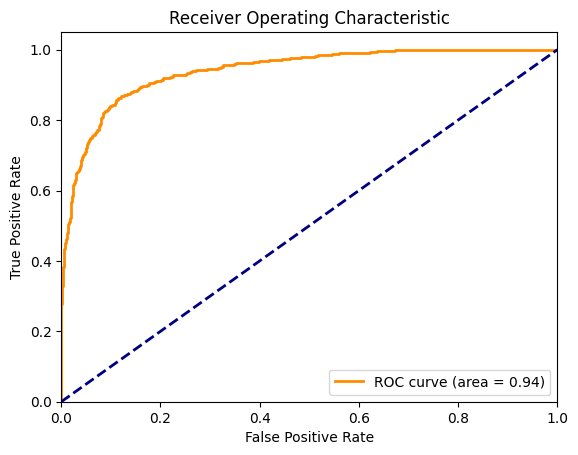

In [90]:
# 11. Visualización de la Curva ROC
y_pred_proba_best = voting_clf_best.predict_proba(X_test)[:,1]
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)
plt.figure()
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Imprimir los resultados

In [91]:
# 12. Imprimir los resultados
print('Mejores hiperparámetros: ', best_params)
print("Matriz de Confusión:")
print(conf_matrix_best)
print("\nInforme de Clasificación:")
print(report_best)
print("\nPrecisión del modelo híbrido:", acc_best)

Mejores hiperparámetros:  {'xgb__subsample': 0.9427629804456301, 'xgb__scale_pos_weight': 1.0320900158332558, 'xgb__reg_lambda': 0.7010703016048032, 'xgb__n_estimators': 651, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.13680927343211416, 'xgb__gamma': 0.04500991430601001, 'xgb__colsample_bytree': 0.8770206411553205, 'rf__n_estimators': 166, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'rf__bootstrap': False, 'ann__epochs': 10, 'ann__batch_size': 71, 'ann__learning_rate': 0.003320651213411407}
Matriz de Confusión:
[[815 139]
 [110 824]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       954
           1       0.86      0.88      0.87       934

    accuracy                           0.87      1888
   macro avg       0.87      0.87      0.87      1888
weighted avg       0.87      0.87      0.87      1888


Precisión del modelo híbrido: 0.868114406779661
